In [7]:
# from cylib.apis.all_api import *
import pickle
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
import warnings

# Suppress the warning
warnings.filterwarnings('ignore', category=pd.errors.SettingWithCopyWarning)

zscore = StandardScaler()

### Remove inappropriate stocks.

In [6]:
# Remove inappropriate stocks.
all_stocks = get_targets_info(target_type='stock')
all_stocks = all_stocks[["ts_code", "name", "list_date", "list_board_name"]]
all_stocks = all_stocks.dropna()
all_stocks['list_date'] = pd.to_datetime(all_stocks['list_date']) 
all_stocks = all_stocks[all_stocks['list_date'] <= pd.to_datetime('2011-07-01')] # Remove stocks before 2011-07-01.
all_stocks = all_stocks[all_stocks['ts_code'].str[0] != 'A'] # Remove unlisted stocks.
all_stocks= all_stocks[all_stocks['list_board_name'] != '北证']
all_stocks = all_stocks[~all_stocks['name'].str.endswith("(IPO终止)")]
all_stocks = all_stocks[~all_stocks['name'].str.endswith("(退市)")] # Remove delisted stocks.
all_stocks = all_stocks[~all_stocks['name'].str.startswith('ST')] # Remove ST
all_stocks = all_stocks[~all_stocks['name'].str.startswith('*ST')] # Remove *ST

# Remove '000792.SZ' and '000670.SZ' as they have missing values.
mask = all_stocks['ts_code'].isin(['000792.SZ', '000670.SZ'])
new_df = all_stocks[mask]

# removing the filtered rows from the original dataframe
all_stocks = all_stocks[~mask]

stocks_code = list(all_stocks['ts_code'])

### Get stocks

In [41]:
# Get stocks

begin_date = '20210101'
end_date = '20240225'
price = get_price(
    ts_code_list=stocks_code,
    feature_list=[
        "open",
        "high",
        "low",
        "close",
        "avg_price",
        "volume",
        "trade_status", # "交易"/"停牌"
    ],
    start_date=begin_date,
    trade_date=end_date,
    target_type="stock",
)
price = price.rename(columns={'open': 'OPEN',
                              'high': 'HIGH',
                              'low': 'LOW',
                              'close': 'CLOSE',
                              'avg_price': 'VWAP',
                              'volume': 'VOLUME'})
price.reset_index(inplace=True)
indexes = ['OPEN', 'HIGH', 'LOW', 'CLOSE', 'VWAP', 'VOLUME']
# Add weekend, If it is Monday, the value is 1, or 0.
# price['Monday'] = (price['trade_date'].dt.dayofweek == 0).astype(int)
price = price.sort_values(by='trade_date').reset_index(drop=True)
# price.set_index(['trade_date', 'ts_code'], inplace=True)
price.fillna(0, inplace=True)
price

,trade_date,ts_code,OPEN,HIGH,LOW,CLOSE,VWAP,VOLUME,trade_status
0,2021-01-04,000001.SZ,19.10,19.10,18.44,18.60,18.6054,1554220.0,交易
1,2021-01-04,002496.SZ,2.57,2.59,2.53,2.59,2.5841,92935.8,交易
2,2021-01-04,600282.SH,3.12,3.16,3.10,3.13,3.1226,402884.0,交易
3,2021-01-04,600973.SH,4.36,4.52,4.35,4.46,4.4587,143660.0,交易
4,2021-01-04,000972.SZ,2.28,2.39,2.26,2.29,2.3342,21704.0,交易
...,...,...,...,...,...,...,...,...,...
1509355,2024-02-23,600210.SH,4.70,4.72,4.61,4.71,4.6741,154395.0,交易
1509356,2024-02-23,600211.SH,45.20,45.20,44.31,44.88,44.7342,25353.4,交易
1509357,2024-02-23,600212.SH,5.85,5.97,5.82,5.89,5.8855,84547.0,交易
1509358,2024-02-23,600215.SH,7.80,7.99,7.62,7.96,7.7882,63317.5,交易


In [11]:
price.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1509360 entries, 0 to 1509359
Data columns (total 9 columns):
 #   Column        Non-Null Count    Dtype         
---  ------        --------------    -----         
 0   trade_date    1509360 non-null  datetime64[ns]
 1   ts_code       1509360 non-null  object        
 2   OPEN          1509360 non-null  float64       
 3   HIGH          1509360 non-null  float64       
 4   LOW           1509360 non-null  float64       
 5   CLOSE         1509360 non-null  float64       
 6   VWAP          1509360 non-null  float64       
 7   VOLUME        1509360 non-null  float64       
 8   trade_status  1509360 non-null  object        
dtypes: datetime64[ns](1), float64(6), object(2)
memory usage: 103.6+ MB


### Get benchmark index
$ \textcolor{red}{Buy \ at \ today's \ open \ and \ sell \ at \ today's\ close.\ (Just\ a \ suppose.)} $

In [9]:
# Get benchmark index
# 1. the Shanghai and Shenzhen 300 index(the HS 300 index)(000300)
# 2. the China Securities 500 index(000905)
# 3. the China Securities 1000 index(000852)
benchmark = get_price(
    ts_code_list=["000300.SH", "000905.SH", "000852.SH"],
    feature_list=[
        "open",
        "high",
        "low",
        "close",
        "volume"
    ],
    start_date=begin_date,
    trade_date=end_date,
    target_type="index",
)
benchmark = benchmark.rename(
    columns={
        "open": "OPEN",
        "high": "HIGH",
        "low": "LOW",
        "close": "CLOSE",
        "volume": 'VOLUME'
    }
)
benchmark.reset_index(inplace=True)
# Add weekend, If it is Monday, the value is 1, or 0.
# benchmark["Monday"] = (benchmark["trade_date"].dt.dayofweek == 0).astype(int)
benchmark = benchmark.sort_values(by="trade_date").reset_index(drop=True)
benchmark.fillna(0, inplace=True)
benchmark

,trade_date,ts_code,OPEN,HIGH,LOW,CLOSE,VOLUME
0,2021-01-04,000300.SH,5212.93,5284.43,5190.94,5267.72,211711000.0
1,2021-01-04,000852.SH,6671.93,6809.43,6662.80,6798.76,183205000.0
2,2021-01-04,000905.SH,6395.61,6501.59,6359.08,6482.79,186621000.0
3,2021-01-05,000300.SH,5245.84,5368.50,5234.38,5368.50,224931000.0
4,2021-01-05,000852.SH,6785.52,6827.50,6726.46,6807.45,197248000.0
...,...,...,...,...,...,...,...
2272,2024-02-22,000300.SH,3450.35,3486.68,3448.41,3486.67,141021000.0
2273,2024-02-22,000852.SH,5075.43,5152.02,5066.00,5151.53,153064000.0
2274,2024-02-23,000852.SH,5169.01,5225.67,5114.15,5225.67,171214000.0
2275,2024-02-23,000300.SH,3491.34,3507.56,3472.97,3489.74,144821000.0


### Get daily return DataFrame

In [10]:
BUY_price = price.pivot(index='trade_date', columns='ts_code', values='OPEN')
BUY_benchmark = benchmark.pivot(index='trade_date', columns='ts_code', values='OPEN')
SELL_price = price.pivot(index='trade_date', columns='ts_code', values='CLOSE')
SELL_benchmark = benchmark.pivot(index='trade_date', columns='ts_code', values='CLOSE')
price_return = (SELL_price - BUY_price) / BUY_price
benchmark_return = (SELL_benchmark - BUY_benchmark) / BUY_benchmark

In [11]:
HS_300 = pd.DataFrame(benchmark_return['000300.SH'])
CS_500 = pd.DataFrame(benchmark_return['000905.SH'])
CS_1000 = pd.DataFrame(benchmark_return['000852.SH'])

### Make predicting label

In [12]:
# Make predicting label

# T+1 to T+11 VWAP return
VWAP_df = price.pivot(index='trade_date', columns='ts_code', values='VWAP')
# VWAP_df.rolling()
VWAP_df

# the change rate of T+1 to T+11
T_begin = 1
T_end = 11
Label_df = (VWAP_df.shift(-T_end) - VWAP_df.shift(-T_begin)) / VWAP_df.shift(-T_begin)
# Attention! zscore.fit_transform() is calculated column by column, so we use Label_df.T
Label_df_processed = pd.DataFrame(zscore.fit_transform(Label_df.T).T,
                                  index=Label_df.index,
                                  columns=Label_df.columns)
trade_date = Label_df.index[: -11]

# Create a dictionary to map trade_date to the corresponding label values
label_dict = Label_df.to_dict(orient='index')
label_dict_processed = Label_df_processed.to_dict(orient='index')

# Define a function to get the label value for a given row (trade_date and stock code)
def get_label(row):
    return label_dict[row['trade_date']][row['ts_code']]
def get_label_peocessed(row):
    return label_dict_processed[row['trade_date']][row['ts_code']]

# Apply the function to create a new 'Label' column in the 'price' dataframe
Label_column = price.apply(get_label, axis=1)
price['Label'] = Label_column
Label_column_processed = price.apply(get_label_peocessed, axis=1)

/home/user/anaconda3/envs/juphub/lib/python3.8/site-packages/sklearn/utils/extmath.py:1051: RuntimeWarning: invalid value encountered in true_divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
/home/user/anaconda3/envs/juphub/lib/python3.8/site-packages/sklearn/utils/extmath.py:1056: RuntimeWarning: invalid value encountered in true_divide
  T = new_sum / new_sample_count
/home/user/anaconda3/envs/juphub/lib/python3.8/site-packages/sklearn/utils/extmath.py:1076: RuntimeWarning: invalid value encountered in true_divide
  new_unnormalized_variance -= correction**2 / new_sample_count


In [13]:
Label_df

ts_code,000001.SZ,000002.SZ,000004.SZ,000006.SZ,000008.SZ,000009.SZ,000010.SZ,000011.SZ,000012.SZ,000014.SZ,...,601919.SH,601933.SH,601939.SH,601958.SH,601988.SH,601989.SH,601991.SH,601992.SH,601998.SH,601999.SH
trade_date,,,,,,,,,,,,,,,,,,,,,
2021-01-04,0.245576,0.146083,-0.011856,-0.000681,0.015254,-0.068275,-0.060200,0.010193,-0.079259,0.048823,...,0.065477,0.026000,0.113583,-0.071575,0.013263,0.035331,0.061648,0.000405,0.020162,-0.041034
2021-01-05,0.196352,0.081457,0.002231,-0.005935,0.012356,-0.032775,-0.077852,-0.025456,-0.055737,0.035240,...,0.026392,0.010589,0.096802,-0.087678,0.009450,0.008829,0.030955,-0.014689,0.016145,-0.023543
2021-01-06,0.139448,0.048281,0.047898,0.002990,0.012582,-0.009435,-0.076721,-0.007229,-0.020140,0.051715,...,0.005730,0.025441,0.074928,-0.090891,0.005317,0.011309,0.021580,-0.013707,0.012996,0.009351
2021-01-07,0.115606,0.008795,0.048033,-0.000038,0.026738,0.051101,-0.042109,-0.005441,0.037354,0.036049,...,0.015590,-0.006780,0.037552,-0.078349,-0.002950,-0.005191,0.005300,-0.025396,-0.000314,-0.005831
2021-01-08,0.081588,-0.027541,0.038893,-0.022203,0.015193,0.043822,-0.026391,-0.028267,0.029310,-0.000091,...,-0.022470,-0.018269,0.013504,-0.029543,-0.005620,-0.011982,0.013184,-0.042691,-0.003027,-0.017271
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-02-19,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2024-02-20,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2024-02-21,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [15]:
trade_date

DatetimeIndex(['2021-01-04', '2021-01-05', '2021-01-06', '2021-01-07',
               '2021-01-08', '2021-01-11', '2021-01-12', '2021-01-13',
               '2021-01-14', '2021-01-15',
               ...
               '2024-01-18', '2024-01-19', '2024-01-22', '2024-01-23',
               '2024-01-24', '2024-01-25', '2024-01-26', '2024-01-29',
               '2024-01-30', '2024-01-31'],
              dtype='datetime64[ns]', name='trade_date', length=749, freq=None)

### Data preprocessing

In [16]:
# Data preprocessing
def value_mapping(row):
    global value_dict
    return value_dict[row['trade_date']][row['ts_code']]

# 3MAD 
def Col_3MAD(row):
    Median = row.median() # median
    mad = (abs(row - Median)).median() # mad = row.mad()
    threshold = 3 * mad
    lower_bound = Median - threshold
    upper_bound = Median + threshold
    return row.clip(lower=lower_bound, upper=upper_bound)

for index in indexes:
    df = price.pivot(index='trade_date', columns='ts_code', values=index)
    values = df.values
    # Standardize for each row
    df = pd.DataFrame(zscore.fit_transform(values.T).T,
                      index=df.index,
                      columns=df.columns)
    df = df.apply(Col_3MAD, axis=1) # 3 times MAD for each row
    value_dict = df.to_dict(orient='index')
    price[index + '_processed'] = price.apply(value_mapping, axis=1)
price['Label_processed'] = Label_column_processed
# It needs to be modified. It is possible to have nan values except for the last 11 days of the time 
# Remove last 11 days' missing data. (T_end - T_begin + 1)
price.dropna(inplace=True)
price

,trade_date,ts_code,OPEN,HIGH,LOW,CLOSE,VWAP,VOLUME,trade_status,Label,OPEN_processed,HIGH_processed,LOW_processed,CLOSE_processed,VWAP_processed,VOLUME_processed,Label_processed
0,2021-01-04,000001.SZ,19.10,19.10,18.44,18.60,18.6054,1554220.0,交易,0.245576,0.041039,0.040387,0.042334,0.042459,0.042563,0.209076,2.796525
1,2021-01-04,002496.SZ,2.57,2.59,2.53,2.59,2.5841,92935.8,交易,0.105683,-0.225449,-0.230577,-0.224426,-0.228294,-0.227264,-0.356536,1.336044
2,2021-01-04,600282.SH,3.12,3.16,3.10,3.13,3.1226,402884.0,交易,-0.021365,-0.214762,-0.219650,-0.213250,-0.217865,-0.216847,0.185715,0.009662
3,2021-01-04,600973.SH,4.36,4.52,4.35,4.46,4.4587,143660.0,交易,-0.044078,-0.190669,-0.193579,-0.188741,-0.192180,-0.190999,-0.267795,-0.227463
4,2021-01-04,000972.SZ,2.28,2.39,2.26,2.29,2.3342,21704.0,交易,-0.140525,-0.231084,-0.234411,-0.229721,-0.234087,-0.232099,-0.481155,-1.234367
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1487509,2024-01-31,601328.SH,5.98,6.03,5.94,6.00,5.9884,1446520.0,交易,0.082874,-0.121945,-0.124176,-0.114444,-0.114532,-0.118345,0.400962,0.514449
1487510,2024-01-31,600735.SH,5.57,5.57,5.16,5.21,5.3499,164325.0,交易,-0.011360,-0.132539,-0.135992,-0.134810,-0.135060,-0.134888,-0.282498,-0.623530
1487511,2024-01-31,000561.SZ,6.99,7.02,6.57,6.59,6.7413,84248.0,交易,0.059117,-0.095849,-0.098746,-0.097995,-0.099202,-0.098837,-0.508898,0.227548
1487512,2024-01-31,600750.SH,21.65,21.73,20.85,21.30,21.2822,94399.9,交易,0.067852,0.104137,0.105721,0.096003,0.095546,0.098929,-0.480196,0.333035


### Data spliting

In [17]:
from sklearn.model_selection import train_test_split

date_train, date_test = train_test_split(trade_date, test_size=0.2, shuffle=False)
price_train = price.loc[price['trade_date'].isin(date_train), :]
date_stock = ['trade_date', 'ts_code']
X_indexes = ['OPEN_processed',
             'HIGH_processed', 
             'LOW_processed', 
             'CLOSE_processed', 
             'VWAP_processed',
             'VOLUME_processed']
y_index = 'Label_processed'
price_X_train = price_train[X_indexes].values
price_y_train = price_train[y_index].values

In [18]:
price_test = price.loc[price['trade_date'].isin(date_test), :]
price_X_test = price_test[X_indexes].values
price_y_test = price_test[y_index].values

In [19]:
print(date_train)
print(date_test)

DatetimeIndex(['2021-01-04', '2021-01-05', '2021-01-06', '2021-01-07',
               '2021-01-08', '2021-01-11', '2021-01-12', '2021-01-13',
               '2021-01-14', '2021-01-15',
               ...
               '2023-06-09', '2023-06-12', '2023-06-13', '2023-06-14',
               '2023-06-15', '2023-06-16', '2023-06-19', '2023-06-20',
               '2023-06-21', '2023-06-26'],
              dtype='datetime64[ns]', name='trade_date', length=599, freq=None)
DatetimeIndex(['2023-06-27', '2023-06-28', '2023-06-29', '2023-06-30',
               '2023-07-03', '2023-07-04', '2023-07-05', '2023-07-06',
               '2023-07-07', '2023-07-10',
               ...
               '2024-01-18', '2024-01-19', '2024-01-22', '2024-01-23',
               '2024-01-24', '2024-01-25', '2024-01-26', '2024-01-29',
               '2024-01-30', '2024-01-31'],
              dtype='datetime64[ns]', name='trade_date', length=150, freq=None)


In [20]:
# Split return rates data
price_return_test = price_return.loc[price_return.index.isin(date_test), :]
benchmark_return_test = benchmark_return.loc[benchmark_return.index.isin(date_test), :]
HS_300_test = HS_300.loc[HS_300.index.isin(date_test), :]['000300.SH']
CS_500_test = CS_500.loc[HS_300.index.isin(date_test), :]['000905.SH']
CS_1000_test = CS_1000.loc[HS_300.index.isin(date_test), :]['000852.SH']

### Model
- MLP
- GBDT
- GRU
- AGRU

In [21]:
from sklearn.neural_network import MLPRegressor
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Attention, Layer, GRU
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from math import sqrt

2024-02-28 11:07:27.593503: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-02-28 11:07:30.826522: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-02-28 11:07:30.837220: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-02-28 11:07:35.135548: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


###  Model——GRU

### Sequence preprocessing

In [26]:
# Create sequences of variable length for each stock
def create_sequences(df, sequence_length, begin_index, end_index):
    """
    sequence length: number of time steps in the entire sequence.
    In this paper, sequence length = 30.

    type: 'train' or 'test'
    
    begin index: index of the first sequence
    end index: index of the last sequence
    """
    sequences = []
    batchs = []
    labels = []
    for stock in df["ts_code"].unique():
        # Single stock dataframe
        stock_df = df[df["ts_code"] == stock].reset_index(drop=True)
        for i in range(sequence_length + begin_index, end_index + 2):
            # The last sequence is included.
            seq = stock_df.iloc[i - sequence_length : i][
                ["OPEN_processed", 
                 "HIGH_processed", 
                 "LOW_processed", 
                 "CLOSE_processed", 
                 "VWAP_processed",
                 "VOLUME_processed"]].values
            label = stock_df.iloc[i - 1]['Label_processed']
            sequences.append(seq)
            labels.append(label)
    return np.array(sequences), np.array(labels)

# Set the desired sequence length
sequence_length = 30

train_X, train_y = create_sequences(price, 
                                    sequence_length, 
                                    0, 
                                    len(date_train) - 1)
test_X, test_y = create_sequences(price, 
                                  sequence_length, 
                                  len(date_train) - sequence_length + 1,
                                  len(trade_date) - 1)

In [27]:
len(test_y) / len(stocks_code)

150.0

In [ ]:
# Define model architecture
model = Sequential() 
model.add(
    GRU(
        30,
        input_shape=(sequence_length, 6),
        return_sequences=True,
        dropout=0.1,
        recurrent_dropout=0.1,
    )
)
model.add(GRU(30, dropout=0.1, recurrent_dropout=0.1))
model.add(Dense(1))

# Compile the model
optimizer = Adam(learning_rate=1e-3)
model.compile(loss="mse", optimizer=optimizer)

# Set up early stopping
early_stopping = EarlyStopping(
    monitor="val_loss", patience=20, restore_best_weights=True
)

# Train the model
# Use batch size equal to number of stocks in training dataset
batch_size = len(stocks_code)
history = model.fit(
    train_X,
    train_y,
    epochs=200,
    batch_size=batch_size,
    callbacks=[early_stopping]
)

# Evaluate the model on test data
y_pred_GRU_train = model.predict(train_X)
y_pred_GRU_test = model.predict(test_X)
mse_GRU_train = mean_squared_error(train_y, y_pred_GRU_train)
mse_GRU_test = mean_squared_error(test_y, y_pred_GRU_test)
print(f"GRU MSE(train): {mse_GRU_train}")
print(f"GRU MSE(test): {mse_GRU_test}")

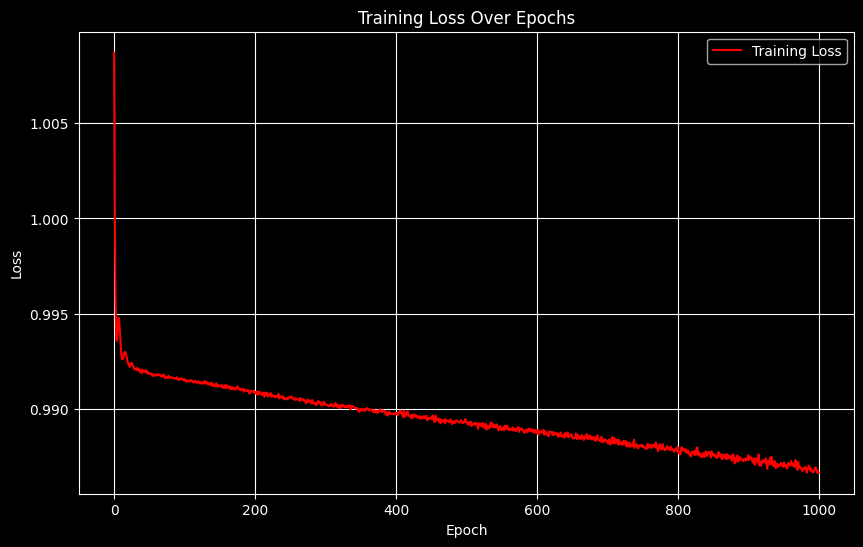

In [ ]:
# Get the loss values from the history object
loss_values = history.history['loss']

# Plot the training loss
plt.figure(figsize=(10, 6))
plt.plot(loss_values, label='Training Loss', color='r')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Over Epochs')
plt.legend()
plt.grid(True)
plt.show()

#### 

### Back testing

In [ ]:
GRU_factor_df = price_test[date_stock] # Date and stock
GRU_factor_df.loc[:, 'Factor_values'] = y_pred_GRU_test # Add factor values
GRU_factor_df = GRU_factor_df.pivot(index='trade_date', 
                      columns='ts_code', 
                      values='Factor_values') # Transfer to factor dataframe
GRU_factor_df

In [ ]:
# layer number
num_layers = 20

# Calculte the ranks of factors daily.
factor_ranks = GRU_factor_df.rank(axis=1, ascending=False)

# The factor ordering is divided into num_layers, each of which allocates funds equally.
layer_allocation = (factor_ranks // (len(GRU_factor_df.columns) / num_layers)).fillna(0)
layer_allocation

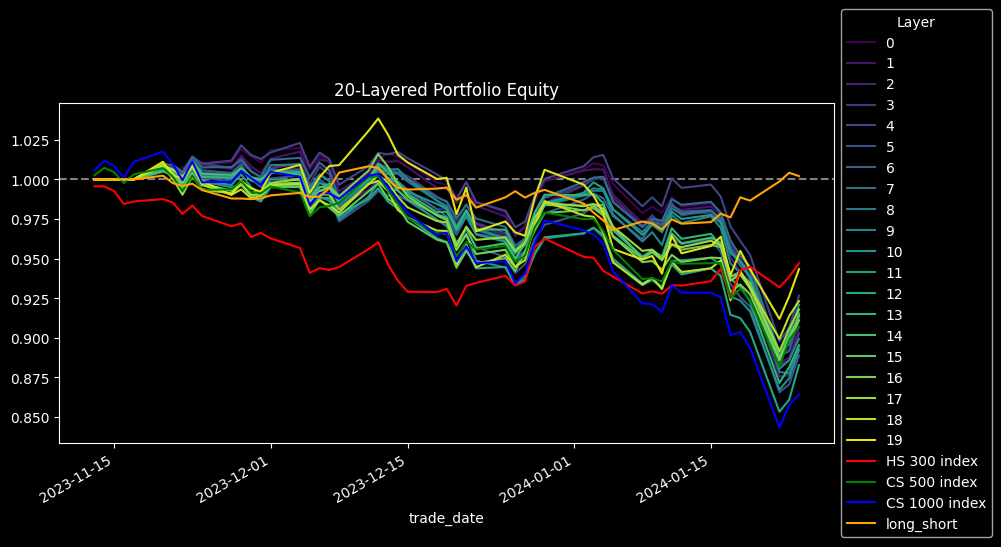

In [ ]:
# import matplotlib.cm as cm

plt.rcParams['axes.unicode_minus'] = False # 正常显示负号
plt.figure(figsize=(10, 5))
plt.axhline(y=1, color='grey', linestyle='--')

# Define a color map to use for changing colors progressively
# colors = plt.cm.jet(np.linspace(0, 1, num_layers))

def Ensure_position(DF):
    # We add a column named 'Monday' and change positions every Monday.
    DF = DF.shift(1) # Move one step forward to ensure position
    DF["Monday"] = (DF.index.dayofweek == 0).astype(int) # Shift except Monday

    # Get the columns to shift (all columns except 'Monday')
    cols_to_shift = DF.columns[DF.columns != 'Monday']

    DF.loc[DF['Monday'] == 0, cols_to_shift] = np.nan
    DF.fillna(method='ffill', inplace=True) # Forward fill, holing positions for a week.
    DF.fillna(value=0, inplace=True) # Fill remaining NaN with 0
    return DF

profit_long = None
profit_short = None
def Long_Short(Num_layers, Layer, Profit):
    global profit_long, profit_short
    if Layer == 0:
        profit_short = Profit
        # The short profit comes from the decline of the stock.
        profit_short = profit_short.apply(lambda x: x + 1 if x == 0 else -x + (1 - 0.0003))
        profit_short = profit_short.cumprod()
        profit_short *= 0.5
    elif Layer == Num_layers - 1:
        profit_long = Profit
        profit_long = profit_long.apply(lambda x: x + 1 if x == 0 else x + (1 - 0.0003))
        profit_long = profit_long.cumprod()
        profit_long *= 0.5

Long_position_df = None
for layer in range(0, num_layers):
    # Ensure holding stocks
    hold_flag_matrix = layer_allocation.mask(layer_allocation != layer, 0).mask(layer_allocation == layer, 1)
    hold_flag_matrix = Ensure_position(hold_flag_matrix)
    if layer == num_layers - 1:
        Long_position_df = hold_flag_matrix

    # Delete 'Monday' to fit into yield dataframe.
    del hold_flag_matrix["Monday"]

    # Calculate the sum of each line in turn.
    stock_amount_sum = hold_flag_matrix.sum(axis=1)

    # Calculate the weight of each stock. (Average distribution at the same level)
    weight_allocation = hold_flag_matrix.apply(lambda x: x / stock_amount_sum, axis=0).fillna(0)

    # Calculate the daily profit rate. And prepare to calculate cumprod.
    profit = (weight_allocation * price_return_test).sum(axis=1)

    # Create Long and Short position
    Long_Short(num_layers, layer, profit)

    # Calculate the daily equity and draw.
    # Using the 'viridis' colormap with a gradient based on layer number
    colors = cm.viridis(layer / num_layers)
    profit = profit.apply(lambda x: x + 1 if x == 0 else x + (1 - 0.0003))
    profit.cumprod().plot(label=layer, legend=True, color=colors)

profit_HS300 = HS_300_test.apply(lambda x: x + 1 if x == 0 else x + (1 - 0.0003))
profit_HS300.cumprod().plot(label="HS 300 index", legend=True, color='r')
profit_CS500 = CS_500_test.apply(lambda x: x + 1 if x == 0 else x + (1 - 0.0003))
profit_CS500.cumprod().plot(label="CS 500 index", legend=True, color='g')
profit_CS1000 = CS_1000_test.apply(lambda x: x + 1 if x == 0 else x + (1 - 0.0003))
profit_CS1000.cumprod().plot(label="CS 1000 index", legend=True, color='b')

(profit_long + profit_short).plot(color='orange', label='long_short', legend=True)
plt.title("20-Layered Portfolio Equity")
plt.legend(title='Layer', bbox_to_anchor=(1, 0.5), loc='center left')
plt.show()

In [ ]:
Long_position_df

### Indexes

1. RankIC mean(IC mean)
2. ICIR
3. IC winning rate
4. IC t-value
5. Long ROI
6. Long sharp
7. Long retracement
8. Long average weekly turnover rate

IC mean: -0.10180622406428705
ICIR: -0.7625237698023178


<Axes: >

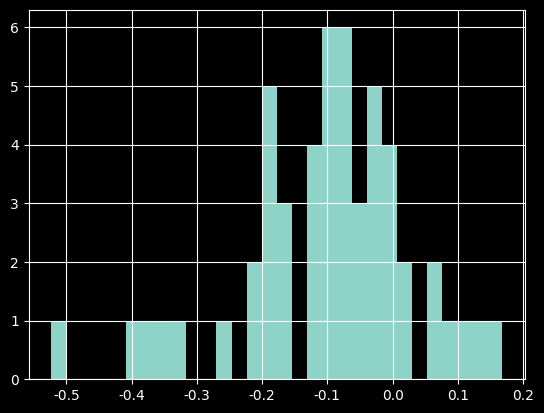

In [ ]:
# ICIR
IC_series = GRU_factor_df.corrwith(price_return_test, 
                                   axis=1,
                                   method='spearman')
IC_mean = IC_series.mean()
print(f'IC mean: {IC_mean}')
ICIR = IC_series.mean() / IC_series.std()
print(f"ICIR: {ICIR}")
IC_series.hist(bins=30)

In [ ]:
# IC winning rate
IC_winning_rate = sum(1 for ic in IC_series if ic > 0) / len(IC_series)
print(f"IC winning rate: {IC_winning_rate}")

IC winning rate: 0.15384615384615385


In [ ]:
t_value = ICIR / sqrt(len(IC_series))
print(f"IC t-value: {t_value}")

IC t-value: -0.10574302118393679


In [ ]:
# Long (Except Short), so `profit_long * 2`
# profit_long is long equity series.
Long_equity = profit_long * 2
Long_ROI = (Long_equity[-1]) - 1
print(f"Long ROI: {Long_ROI}")

# Max Drawdown
# Calculate the previous peaks
previous_peaks = Long_equity.cummax()
# Calculate the drawdowns
drawdowns = (Long_equity - previous_peaks) / previous_peaks

# Find the maximum drawdown and the dates associated with it
# Convert the index labels to a numeric format
drawdowns.index = pd.to_numeric(drawdowns.index)
max_drawdown = drawdowns.min()
print(f'Max drawdown: {max_drawdown}')
max_drawdown_start = drawdowns.idxmin()

# Convert the start and end dates back to the original format if needed
max_drawdown_start = pd.to_datetime(max_drawdown_start).date()
print(f"Max drawdown begin date: {max_drawdown_start}")

Long ROI: 0.8867063115820051
Max drawdown: -0.12197870311482398
Max drawdown begin date: 2024-01-22
